In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
# core jax imports
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap, random
import torch
import shutil

# flax is neural-network library
import flax
from flax import linen as nn
# help create state update
from flax.training import train_state

# nnx is another pytorch-like api for flax, which is still in its infancy
# from flax import nnx as nn

# optax is optimization libaray
import optax

# typing library in python, this library is useful for type-hinting and to make the function inputs/ouputs and class initialization variables to have fixed data type
from typing import Any, Callable, Sequence, Tuple

from functools import partial

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os

import orbax
import orbax.checkpoint as ocp
from flax.training import orbax_utils
from tqdm import trange

import math

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [ ]:
from typing import NamedTuple, Any

class TimedX(NamedTuple):
  t: Any
  x: jnp.ndarray

def gaussians(jseed, t):
  jseeds = random.split(jseed, 3)
  x_1 = random.randint(jseeds[0], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_1 = x_1.astype(float)-0.5
  x_1 += 1e-1*random.normal(jseeds[1], shape=(t.shape[0],2))
  x_0 = 1e-1*random.normal(jseeds[2], shape=(t.shape[0],2))
  x_t = (1-t)*x_0 + t*x_1
  return x_0, x_1, x_t

def diamonds(jseed, t):
  jseeds = random.split(jseed, 4)
  x_1 = random.randint(jseeds[0], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_1 = x_1.astype(float)-0.5
  x_1 = x_1.at[:,0].set(0.5)

  x_0 = random.randint(jseeds[1], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_0 = x_0.astype(float)-0.5
  x_0 = x_0.at[:,0].set(-0.5)

  R = jnp.array([[1/math.sqrt(2),-1/math.sqrt(2)],
                 [1/math.sqrt(2),1/math.sqrt(2)]])
  x_1 += 5e-1*(random.uniform(jseeds[2], shape=(t.shape[0],2))-0.5)@R
  x_0 += 5e-1*(random.uniform(jseeds[3], shape=(t.shape[0],2))-0.5)@R
  x_t = (1-t)*x_0 + t*x_1
  
  return x_0, x_1, x_t


def squares(jseed, t):
  jseeds = random.split(jseed, 3)
  x_0 = random.uniform(jseeds[0], shape=(t.shape[0], 2)) - 0.5 + jnp.array([-1.0, 0])
  x_1 = random.uniform(jseeds[1], shape=(t.shape[0], 2)) - 0.5 + jnp.array([1.0, 0])

    
  x_t = (1-t)*x_0 + t*x_1

  return x_0, x_1, x_t

def chessboard(key, t):
    x = []
    y = []
    subkey_idx = 0
    n_samples = len(t)

    for i in range(-2, 2):
        for j in range(-2, 2):
            if (i + j) % 2 == 0:
                # Create new keys for each box
                key_x, key_y = jax.random.split(jax.random.fold_in(key, subkey_idx))
                subkey_idx += 1

                # Generate random samples
                x_box = jax.random.uniform(key_x, shape=(n_samples // 8,)) + i
                y_box = jax.random.uniform(key_y, shape=(n_samples // 8,)) + j

                x.append(x_box)
                y.append(y_box)

    # Concatenate lists into arrays
    x = jnp.concatenate(x)
    y = jnp.concatenate(y)

    x_0= jnp.vstack((x, y)).T
    x_1 = x_0 + jnp.array([6.0, 0])
    x_t = (1-t)*x_0 + t*x_1

    return x_0, x_1, x_t

# DEFINE THE DYNAMICS TO USE HERE
# q_t = squares
q_t = diamonds
# q_t = gaussians


def sample_t(u0, n, t0=0.0, t1=1.0):
    u = (u0 + math.sqrt(2) * jnp.arange(n + 1)) % 1  # Generate n+1 samples and apply modulo 1
    u = u.reshape([-1, 1])                           # Reshape u to a column vector
    return u[:-1] * (t1 - t0) + t0, u[-1]

In [16]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
DS = 4000
key, loc_key = random.split(key)
DATA_0, DATA_1, _ = q_t(loc_key, jnp.ones([DS,1]))

In [17]:
DATA_1

Array([[ 0.37825745,  0.59783316],
       [ 0.58291847, -0.65787727],
       [ 0.3856426 , -0.6687867 ],
       ...,
       [ 0.5075019 , -0.48727325],
       [ 0.4450133 , -0.46883008],
       [ 0.71879226, -0.40679398]], dtype=float32)

In [18]:
DATA_0

Array([[-0.50910676, -0.2164661 ],
       [-0.59940344, -0.4473169 ],
       [-0.49758098,  0.39814013],
       ...,
       [-0.43372324, -0.21533799],
       [-0.2927276 ,  0.50637996],
       [-0.4457008 ,  0.21876395]], dtype=float32)

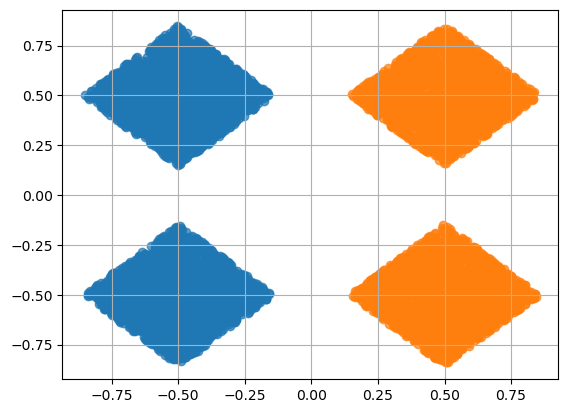

In [19]:
# figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7, label="source")
plt.scatter(DATA_1[:,0], DATA_1[:,1], alpha=0.7, label="target")
# plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

In [ ]:
class Smodel(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = jnp.hstack([t,h])
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = jnp.hstack([t,h])
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = jnp.hstack([t,h])
    h = nn.Dense(self.num_out)(h)
    return h


class Qmodel(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x_0, x_1):
    h = jnp.hstack([t, x_0, x_1, t<0.5]) 
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = jnp.hstack([t, h])
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = jnp.hstack([t, h])
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = jnp.hstack([t, h])
    h = nn.Dense(self.num_out)(h)
    out = (1-t)*x_0 + t*(x_1 + h) 
    
    return out

# class Qmodel(nn.Module):
#   num_hid : int
#   num_out : int
#   @nn.compact
#   def __call__(self, t, x_0, x_1):
      
#     def transport_net(inputs):
#       MLP_out = nn.Sequential([
#             nn.Dense(self.num_hid),
#             nn.swish,
#             nn.Dense(self.num_hid),
#             nn.swish,
#             nn.Dense(self.num_hid),
#             nn.swish,
#             nn.Dense(self.num_hid),
#             nn.swish,
#             nn.Dense(self.num_out),
#         ])(inputs)
#       ResConnect = nn.Dense(self.num_out)(inputs)
#       return MLP_out + ResConnect
#     x_1_tilde = transport_net(x_1)
#     h = jnp.hstack([t, x_0, x_1, x_1_tilde, t<0.5]) # removed the heaviside 
#     h = nn.Dense(self.num_hid)(h)
#     h = nn.swish(h)
#     h = jnp.hstack([t, h])
#     h = nn.Dense(self.num_hid)(h)
#     h = nn.swish(h)
#     h = jnp.hstack([t, h])
#     h = nn.Dense(self.num_hid)(h)
#     h = nn.swish(h)
#     h = jnp.hstack([t, h])
#     h = nn.Dense(self.num_out)(h)
      
#     out = (1-t)*x_0 + t*(x_1_tilde + (1-t)*h)
#     return out

@flax.struct.dataclass
class State:
  step: int
  opt_state: Any
  model_params: Any
  ema_params: Any
  ema_rate: Any

In [9]:
### Model and parameter intialization
s_net = Smodel(num_hid=512, num_out=1)
q_net = Qmodel(num_hid=512, num_out=2)

seed = 0

BS = 512
##############################
c= 2.0
##############################
wf_lr = 1e-3
key = random.key(0)
key, *init_keys = random.split(key, 3)

# Specify the clipping threshold
clip_value = 1.0 # we do not use it in our implementation

optimizer_s = optax.chain(optax.adam(learning_rate=1e-4))
optimizer_q = optax.chain(optax.adam(learning_rate=1e-4))

init_params_s = s_net.init(init_keys[0], np.ones([BS,1]), DATA_0[:BS])
init_params_q = q_net.init(init_keys[1], np.ones([BS,1]), DATA_0[:BS], DATA_1[:BS])

opt_state_s = optimizer_s.init(init_params_s)
opt_state_q = optimizer_q.init(init_params_q)

state_s = State(step=0, opt_state=opt_state_s, model_params=init_params_s, ema_params=init_params_s, ema_rate=0.999)
state_q = State(step=0, opt_state=opt_state_q, model_params=init_params_q, ema_params=init_params_q, ema_rate=0.999)

In [ ]:
# mechanics for rejection sampler
# majority of code is curated from chapt-gpt
# create dataset and rejection sampler
import tensorflow as tf

def create_dataset(file_list, repeat=True, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(file_list)
    dataset_options = tf.data.Options()
    # Set dataset options
    dataset_options.experimental_optimization.map_parallelization = True
    dataset_options.threading.private_threadpool_size = 48
    dataset_options.threading.max_intra_op_parallelism = 1
    # dataset = dataset.map(lambda x: (preprocess_image(x)),  num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.with_options(dataset_options)
    dataset = dataset.repeat(count=num_epochs)
    dataset = dataset.batch(batch_size = BS, drop_remainder=True)
    return dataset.prefetch(tf.data.AUTOTUNE)


class PeriodicPhiFilteredTFDSFlax:
    def __init__(self, base_dataset, phi_model, params, batch_size=64,
                 refresh_every=500, min_acceptance_ratio=0.1, candidate_batch_size=2048):
        """
        Parameters:
        - base_dataset: tf.data.Dataset yielding (x,) or (x, y)
        - phi_model: Flax model (Module)
        - params: Current parameters of φ
        - batch_size: final training batch size
        - refresh_every: how often to refresh filtering
        - min_acceptance_ratio: fallback to full data if acceptance too low
        - candidate_batch_size: batch size for φ evaluation
        """
        self.base_dataset = base_dataset
        self.phi_model = phi_model
        self.params = params
        self.batch_size = batch_size
        self.refresh_every = refresh_every
        self.min_acceptance_ratio = min_acceptance_ratio
        self.candidate_batch_size = candidate_batch_size
        self.step = 0
        self.dataset = self.base_dataset

        # self._refresh_dataset()

    def _evaluate_phi(self, x_batch):
        """Runs φ(x) on a batch of TensorFlow tensors using Flax model on GPU."""
        x_batch_jax = jax.device_put(tf.convert_to_tensor(x_batch).numpy())  # to JAX array
        phi_vals = self.phi_model.apply(self.params, jnp.ones((len(x_batch_jax), 1)), x_batch_jax).squeeze()
        return jax.device_get(phi_vals)  # return as NumPy array for filtering

    def _refresh_dataset(self):
        print(f"[INFO] Refreshing dataset at step {self.step}...")
        candidate_ds = self.base_dataset.unbatch().batch(self.candidate_batch_size)

        accepted_x, accepted_y = [], []
        total, accepted = 0, 0

        for batch in candidate_ds:
            if isinstance(batch, tuple):
                x_batch, y_batch = batch
            else:
                x_batch, y_batch = batch, None

            phi_vals = self._evaluate_phi(x_batch)
            mask = phi_vals <= 1.0e-5

            total += len(phi_vals)
            accepted += jnp.sum(mask)

            accepted_x.append(tf.boolean_mask(x_batch, mask))
            if y_batch is not None:
                accepted_y.append(tf.boolean_mask(y_batch, mask))

        acceptance_ratio = accepted / total if total > 0 else 0
        print(f"[INFO] φ-based acceptance rate: {acceptance_ratio:.2%}")

        if acceptance_ratio < self.min_acceptance_ratio:
            print("[WARN] Too few accepted — using full dataset.")
            # self.dataset = self._make_dataset_from_tfds(self.base_dataset)
            self.dataset = self.dataset
        else:
            x_all = tf.concat(accepted_x, axis=0)
            y_all = tf.concat(accepted_y, axis=0) if accepted_y else None
            self.dataset = self._make_dataset(x_all, y_all)

    def _make_dataset(self, x, y):
        if y is None:
            ds = tf.data.Dataset.from_tensor_slices(x)
        else:
            ds = tf.data.Dataset.from_tensor_slices((x, y))
        return ds.shuffle(10_000).batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

    def _make_dataset_from_tfds(self, ds):
        return ds.shuffle(10_000).batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

    def update_if_needed(self, step, new_params=None):
        self.step = step
        if step % self.refresh_every == 0 and step>0:
            if new_params is not None:
                self.params = new_params
            self._refresh_dataset()

    def get_dataset(self):
        return self.dataset



2025-10-09 02:16:55.105132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759990615.127507   93643 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759990615.134259   93643 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
N_pts = 100_000
u0 = jax.random.uniform(key, 1)
t_, _ = sample_t(u0, N_pts)
X0, X1, _ = q_t(random.PRNGKey(0), t_)
num_epochs = 1
source_ds = create_dataset(X0)
target_ds = create_dataset(X1)

source_iter = iter(source_ds)
data_filter = PeriodicPhiFilteredTFDSFlax(target_ds, s_net, state_s.model_params, batch_size=BS,
                 refresh_every=100, min_acceptance_ratio=0.1, candidate_batch_size=2048) 

target_iter = iter(target_ds)
target_iter_phi = iter(data_filter.get_dataset())

I0000 00:00:1759990621.034524   93643 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30858 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0
I0000 00:00:1759990621.035112   93643 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31132 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


In [ ]:
step = 0
min_filter_step = 20000

def get_model_fn(model, params):
    def model_fn(t,x):
        return model.apply(params, t, x)
    return model_fn

# @partial(jax.jit, static_argnums=2)
def get_loss_s(model_s, model_q, wgf_steps, wgf_step_size):
    def loss_s(params_s, params_q, data_batch, time_batch, key):
        s = get_model_fn(model_s, params_s)
        dsdtdx_fn = jax.grad(lambda t,x: s(t,x).sum(), argnums=[0,1])
        
        def potential(t, x):    
          dsdt, dsdx = dsdtdx_fn(t, x)
          return dsdt + 0.5*(dsdx**2).sum(1, keepdims=True)
            
        acceleration_fn = jax.grad(lambda t, x: potential(t, x).sum(), argnums=1)
        
        t=time_batch
        t_0, t_1 = jnp.zeros([len(t), 1]),  jnp.ones([len(t), 1])
        
        x_0, x_1, x_1t =  data_batch[0], data_batch[1], data_batch[2]
        # x_1p, h = model_q.apply(params_q, t, x_0, x_1t)
        # x_t = (1-t)*x_0 + t*x_1p + t*(1-t)*h
        x_t = model_q.apply(params_q, t, x_0, x_1t)

        for wgf_iter in range(0, wgf_steps):
            update = jax.lax.stop_gradient(acceleration_fn(t, x_t))
            x_t = x_t + wgf_step_size * jnp.clip(update, -1, 1)
        
        x_t = jax.lax.stop_gradient(x_t)
        
        loss = s(t_0, x_0).mean() + c*jax.nn.relu(- s(t_1, x_1)).mean() 
        loss += potential(t, x_t).mean()

        update = jax.lax.stop_gradient(acceleration_fn(t, x_t))
 
        return loss.mean(), jnp.sqrt((update**2).sum(1)).mean()
    return loss_s

# @partial(jax.jit, static_argnums=2)
def get_loss_q(model_s, model_q, wgf_steps, wgf_step_size):
    def loss_q(params_s, params_q, data_batch, time_batch, key):
        s_stopped = get_model_fn(model_s, jax.lax.stop_gradient(params_s))
        dsdtdx_fn_stopped = jax.grad(lambda t,x: s_stopped(t,x).sum(), argnums=[0,1])
        
        def potential_stopped(t, x):    
          dsdt, dsdx = dsdtdx_fn_stopped(t, x)
          return dsdt + 0.5*(dsdx**2).sum(axis=1, keepdims=True)
            
        acceleration_fn = jax.grad(lambda t, x: potential_stopped(t, x).sum(), argnums=1)

        t=time_batch
        t_0, t_1 = jnp.zeros([len(t), 1]),  jnp.ones([len(t), 1])
        x_0, x_1, x_1t =  data_batch[0], data_batch[1], data_batch[2]
        
        x_t = model_q.apply(params_q, t, x_0, x_1t)
        
        update = jax.lax.stop_gradient(acceleration_fn(t, x_t))
        
        loss = - potential_stopped(t,x_t).mean()

        update = jax.lax.stop_gradient(acceleration_fn(t, x_t))
        return loss,  jnp.sqrt((update**2).sum(1)).mean()
        
    return loss_q


@partial(jax.jit, static_argnums=(2,3,4))
def train_step(state_s, state_q, s_steps, q_steps, wgf_steps, wgf_lr, key):
  keys = random.split(key)

  loss_fn_s = get_loss_s(s_net, q_net, wgf_steps=wgf_steps, wgf_step_size=wgf_lr)
  loss_fn_q = get_loss_q(s_net, q_net, wgf_steps=wgf_steps, wgf_step_size=wgf_lr)
    
  grad_fn_s = jax.value_and_grad(loss_fn_s, argnums=[0], has_aux=True)
  grad_fn_q = jax.value_and_grad(loss_fn_q, argnums=[1], has_aux=True)

  params_s = state_s.model_params
  params_q = state_q.model_params
      
  opt_state_s =state_s.opt_state
  opt_state_q =state_q.opt_state
      
  for s_iters in range(0, s_steps):
      # t = random.uniform(keys[0], [BS,1])
      
      u0 = jax.random.uniform(key, 1)
      t, _ = sample_t(u0, BS)
      
      x0 = next(source_iter)
      x1 = next(target_iter)
      
      if step >= min_filter_step:
          x1t = next(target_iter_phi)
      else:
          x1t = x1
      
      # x0, x1, _ =  q_t(key, t)
      batch_x = [jnp.asarray(x0), jnp.asarray(x1), jnp.asarray(x1t)]
      
      (loss_s_val, gradV), grad_s = grad_fn_s(params_s, params_q, batch_x, t, key)
      updates_s, opt_state_s = optimizer_s.update(grad_s[0], opt_state_s, params_s)
      params_s = optax.apply_updates(params_s, updates_s)
      new_ema_params_s = jax.tree_util.tree_map(lambda p_ema, p: p_ema * state_s.ema_rate + p * (1. - state_s.ema_rate),
                                                state_s.ema_params, params_s)

  for q_iters in range(0, q_steps):
      # t = random.uniform(keys[1], [BS,1])

      u0 = jax.random.uniform(key, 1)
      t, _ = sample_t(u0, BS)

      x0 = next(source_iter)
      x1 = next(target_iter)
      
      if step >= min_filter_step:
          x1t = next(target_iter_phi)
      else:
          x1t = x1
      
      # x0, x1, _ =  q_t(key, t)
      batch_x = [jnp.asarray(x0), jnp.asarray(x1), jnp.asarray(x1t)]
      
      (loss_q_val, gradV), grad_q = grad_fn_q(params_s, params_q, batch_x, t, key)
      updates_q, opt_state_q = optimizer_q.update(grad_q[0], opt_state_q, params_q)
      params_q = optax.apply_updates(params_q, updates_q)
      new_ema_params_q = jax.tree_util.tree_map(lambda p_ema, p: p_ema * state_q.ema_rate + p * (1. - state_q.ema_rate),
                                                state_q.ema_params, params_q)

  state_s = state_s.replace(step=state_s.step+1, opt_state=opt_state_s, model_params=params_s, ema_params=new_ema_params_s)
  state_q = state_q.replace(step=state_q.step+1, opt_state=opt_state_q, model_params=params_q, ema_params=new_ema_params_q)
  
  return state_s, state_q, loss_s_val, loss_q_val, gradV


key, loc_key = random.split(key)
_, _, _, _, _ = train_step(state_s, state_q, 2, 2, 5, wf_lr, loc_key)

In [13]:
# x = random.PRNGKey(0)

In [15]:
num_iterations = 50_000
u0 = 0.0
# u0 = 0
s_step_num=5
q_step_num=1
wf_step_num=0
save_interval_steps =20_000
log_every_step = 1000
eval_evey_step = 1000
min_filter_step = 10_000
# target_ds_filtered = PeriodicPhiFilteredTFDSFlax(s_net, )
target_refresh_step = 100
data_filter = PeriodicPhiFilteredTFDSFlax(target_ds, s_net, state_s.model_params, batch_size=BS,
                 refresh_every=target_refresh_step, min_acceptance_ratio=0.1, candidate_batch_size=2048) 

target_iter_phi = iter(data_filter.get_dataset())

######
ckpt_path = "/lustre/cniel/neural-ot-ss/lagrangian-pot-flows/mnist-emnist/" + "checkpoints/"+ q_t.__name__ + "/c={0}/".format(c)
# ckpt_path_ = ocp.test_utils.erase_and_create_empty(ckpt_path)
ckpt_path0 =  ckpt_path+"0"
if os.path.exists(ckpt_path0):
    shutil.rmtree(ckpt_path0)

checkpointer = ocp.Checkpointer(ocp.CompositeCheckpointHandler('state_s', 'state_q'))
checkpointer.save(ckpt_path0, args=ocp.args.Composite(state_s=ocp.args.StandardSave(state_s),state_q=ocp.args.StandardSave(state_q)))   
# checkpointer.save(ckpt_path0, args=ocp.args.Composite(state_s=state_s,state_q=state_q))

# for the rest iterations
#options = ocp.CheckpointManagerOptions(max_to_keep=60, save_interval_steps=save_interval_steps)
options = ocp.CheckpointManagerOptions(max_to_keep=60)
ckpt_mgr = ocp.CheckpointManager(ckpt_path, options=options, item_names={"state_s", "state_q"})
ckpt_mgr.save(0, args=ocp.args.Composite(state_s=ocp.args.StandardSave(state_s),state_q=ocp.args.StandardSave(state_q)))
# ckpt = {"state_s": state_s, "state_q":state_q}
# ckpt_mgr.save(0, args=ocp.args.Composite(state_s=ocp.args.StandardSave(state_s),state_q=ocp.args.StandardSave(state_q)))

#########################################
#training loop

import wandb
wandb.init(project="toy squares", name="c={}".format(c))

loss_s_plot = np.zeros(num_iterations+1)
loss_q_plot = np.zeros(num_iterations+1)
gradV_plot = np.zeros(num_iterations+1)
for step in range(num_iterations+1):
  if step >= min_filter_step:
      data_filter.update_if_needed(step, state_s.model_params)
      if step % target_refresh_step == 0:
          target_iter_phi = iter(data_filter.get_dataset())
  key, loc_key = random.split(key)
  # state_s, state_q, state_psi, loss, gradV,_ = train_step(state_s, state_q, state_psi, wf_lr, loc_key)
  state_s, state_q, loss_s_val, loss_q_val, gradV = train_step(state_s, state_q, s_step_num, q_step_num, wf_step_num, wf_lr, key)

  # with ocp.CheckpointManager(ckpt_path, options=options, item_names={"state_s", "state_q"})  as ckpt_mgr:
  #     ckpt_mgr.save(iter, args=ocp.args.Composite(state_s=ocp.args.StandardSave(state_s),state_q=ocp.args.StandardSave(state_q)))
  
  # checkpointer updates
  # checkpointer updates
  if (step)%save_interval_steps == 0:
      ckpt = {"state_s": state_s, "state_q":state_q}
      ckpt_mgr.save(step, args=ocp.args.Composite(state_s=ocp.args.StandardSave(state_s),state_q=ocp.args.StandardSave(state_q)))
      ckpt_mgr.wait_until_finished()

  if (step)%log_every_step == 0:
    wandb.log({"loss_s": loss_s_val, "loss_q": loss_q_val, "gradV": gradV}, step=step)

  loss_s_plot[step] = loss_s_val
  loss_q_plot[step] = loss_q_val
  gradV_plot[step] = gradV

  if (step)%eval_evey_step == 0:
      dsdx_fn = jax.jit(jax.grad(lambda t, x, p: s_net.apply(p,t,x).sum(), argnums=1))
      dt = 1e-2
      t = 0.0
      n = int(1/dt)
      x = np.zeros((DS,n+1,2))
      x[:,0,:] = DATA_0
      x_t = np.zeros((DS,n+1,2))
      x_t[:,0,:] = DATA_0
      t = np.zeros((DS,n+1,1))
      key, iter_key = random.split(key)
      for i in range(n):
          x[:,i+1,:] = x[:,i,:] + dt*dsdx_fn(t[:,i,:], x[:,i,:], state_s.model_params)
          t[:,i+1,:] = t[:,i,:] + dt
          # x_1p, ht = q_net.apply(state_q.model_params, t[:,i,:], DATA_0, DATA_1)
          # x_t[:,i+1,:] = (1-t[:,i+1,:]) * DATA_0 + t[:,i+1,:] * x_1p + t[:,i+1,:] * (1 - t[:,i+1,:]) * ht
          x_t[:, i+1, :] = q_net.apply(state_q.model_params, t[:,i,:], DATA_0, DATA_1)
      fig, axs = plt.subplots(1,1)
      axs.scatter(DATA_0[:,0], DATA_0[:,1], fc="r", alpha=0.7)
      axs.scatter(DATA_1[:,0], DATA_1[:,1], fc = "g", alpha=0.7)
      axs.scatter(x[:,-1,0], x[:,-1,1], fc="k", alpha=0.5)
      axs.scatter(x_t[:,-1,0], x_t[:,-1,1], fc = 'r', alpha=0.7)
      for i in range(DS):
          axs.plot(x[i,:,0], x[i,:,1], "b:", alpha=0.1)
        # plt.xlim(-1.5,1.5)
      axs.grid()
      wandb.log({"transported": wandb.Image(fig)})
      plt.close(fig)
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bilalriaz (bilalriaz-University of Delaware). Use `wandb login --relogin` to force relogin


[INFO] Refreshing dataset at step 10000...
[INFO] φ-based acceptance rate: 46.78%
[INFO] Refreshing dataset at step 10100...
[INFO] φ-based acceptance rate: 45.29%
[INFO] Refreshing dataset at step 10200...
[INFO] φ-based acceptance rate: 48.92%
[INFO] Refreshing dataset at step 10300...
[INFO] φ-based acceptance rate: 50.88%
[INFO] Refreshing dataset at step 10400...
[INFO] φ-based acceptance rate: 49.54%
[INFO] Refreshing dataset at step 10500...
[INFO] φ-based acceptance rate: 49.54%
[INFO] Refreshing dataset at step 10600...
[INFO] φ-based acceptance rate: 49.50%
[INFO] Refreshing dataset at step 10700...
[INFO] φ-based acceptance rate: 50.07%
[INFO] Refreshing dataset at step 10800...
[INFO] φ-based acceptance rate: 50.22%
[INFO] Refreshing dataset at step 10900...
[INFO] φ-based acceptance rate: 49.46%
[INFO] Refreshing dataset at step 11000...
[INFO] φ-based acceptance rate: 49.41%
[INFO] Refreshing dataset at step 11100...
[INFO] φ-based acceptance rate: 49.22%
[INFO] Refreshin

gradV,▂▃▂▁▂▂▂▁▃▂▂█▂▁▂▁▂▂▂▂▂▁▂▂▃▃▃▄▂▂▂▃▄▃▄▃▅▄▃▄
loss_q,▇██▇▆▇▆▇▇▇▇▇▇█▆▅▅▅▄▅▃▄▁▃▁▃▃▄▄▃▅▄▄▁▆▃▆▇▅▇
loss_s,█▃▃▃▃▃▃▂▃▃▃▃▃▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃
gradV,0.83424
loss_q,0.01144
loss_s,-0.38598


Text(0, 0.5, '$\\nabla$s')

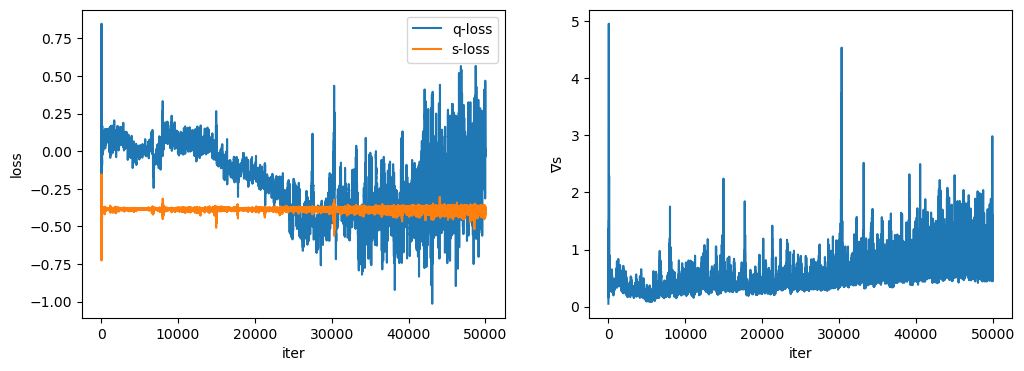

In [21]:
figsize(12,4)
plt.subplot(121)
plt.plot(loss_q_plot, label="q-loss")
plt.plot(loss_s_plot, label="s-loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
# plt.ylim(-50, 50)
# plt.grid()
plt.subplot(122)

plt.plot(gradV_plot)
plt.xlabel("iter")
plt.ylabel("$\\nabla$s")
# plt.ylim(0.0, 5.0)
# plt.grid()

In [22]:
def V(t, x, p):
  dsdtdx_fn = jax.grad(lambda t, x, p: s_net.apply(p,t,x).sum(), argnums=[0,1])
  dsdt, dsdx = dsdtdx_fn(t, x, p)
  return dsdt + 0.5*(dsdx**2).sum(1, keepdims=True)
dVdx_fn = jax.grad(lambda t, x, p: V(t,x,p).sum(), argnums=1)
# and to apply the model
dsdx_fn = jax.jit(jax.grad(lambda t, x, p: s_net.apply(p,t,x).sum(), argnums=1))
val_dsdx_fn = jax.jit(jax.value_and_grad(lambda t, x, p: s_net.apply(p,t,x).sum(), argnums=1))

dt = 1e-2
t = 0.0
n = int(1/dt)
x = np.zeros((DS,n+1,2))
x[:,0,:] = DATA_0
x_t = np.zeros((DS,n+1,2))
x_t[:,0,:] = DATA_0
t = np.zeros((DS,n+1,1))
key, iter_key = random.split(key)
for i in trange(n):
  x[:,i+1,:] = x[:,i,:] + dt*dsdx_fn(t[:,i,:], x[:,i,:], state_s.model_params)
  t[:,i+1,:] = t[:,i,:] + dt
  x_t[:,i+1,:] = q_net.apply(state_q.model_params, t[:,i,:], DATA_0, DATA_1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.04it/s]


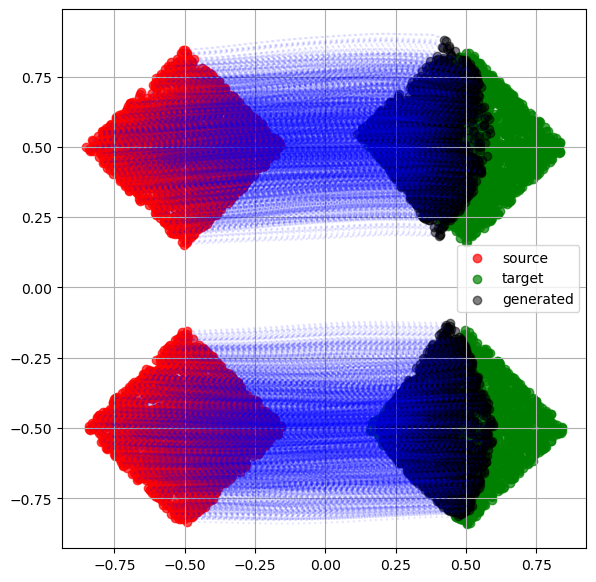

In [23]:
plt.figure(figsize=(23, 7))
plt.scatter(DATA_0[:,0], DATA_0[:,1], fc="r", alpha=0.7, label="source")
plt.scatter(DATA_1[:,0], DATA_1[:,1], fc="g", alpha=0.7, label="target")
plt.scatter(x[:,-1,0], x[:,-1,1], fc="k", alpha=0.5, label="generated")

for i in range(DS):
    plt.plot(x[i,:,0], x[i,:,1], "b:", alpha=0.1)

plt.grid()
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')  # Make plot square
plt.show()

/home/2145/NOT/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


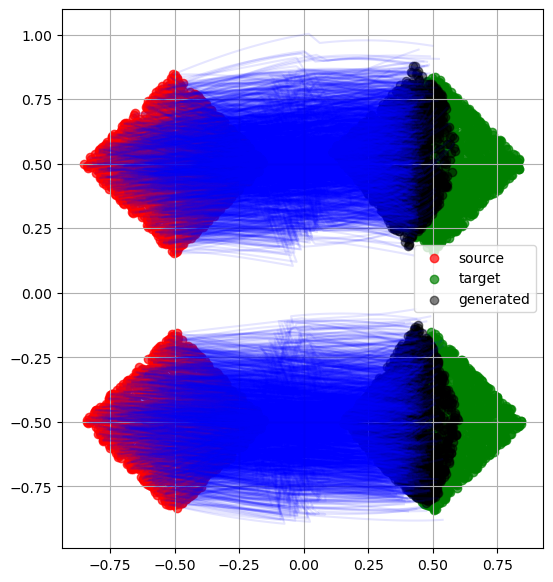

In [24]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], fc="r", alpha=0.7, label = "source")
plt.scatter(DATA_1[:,0], DATA_1[:,1], fc = "g", alpha=0.7, label = "target")
plt.scatter(x[:,-1,0], x[:,-1,1], fc="k", alpha=0.5, label = "generated")
for i in range(DS):
  plt.plot(x_t[i,:,0], x_t[i,:,1], c='b', alpha=0.1)
# plt.xlim(-1.5,1.5)
plt.grid()
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')  # Make plot square
plt.show()

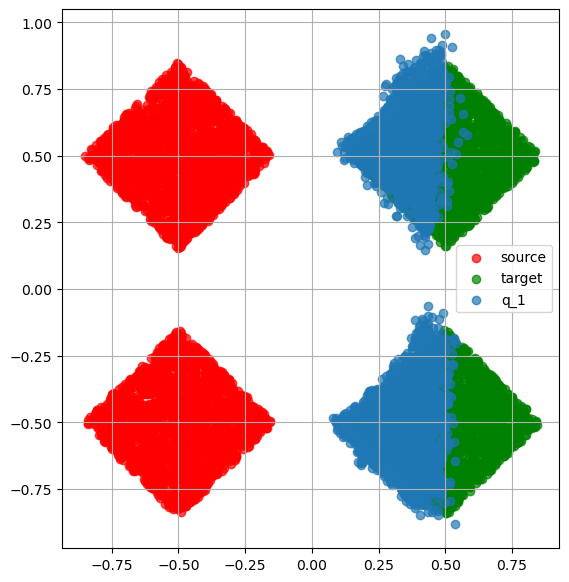

In [25]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], fc="r", alpha=0.7, label = "source")
plt.scatter(DATA_1[:,0], DATA_1[:,1], fc = "g", alpha=0.7, label = "target")
# plt.scatter(x[:,-1,0], x[:,-1,1], fc="k", alpha=0.5, label = "generated")
plt.scatter(x_t[:,-1,0], x_t[:,-1,1], alpha=0.7, label = "q_1")
# for i in range(DS):
#   plt.scatter(x_t[i,:,0], x_t[i,:,1], c='k', alpha=0.1)
# plt.xlim(-1.5,1.5)
plt.gca().set_aspect('equal', adjustable='box')  # Make plot square
plt.legend()
plt.grid()
plt.show()

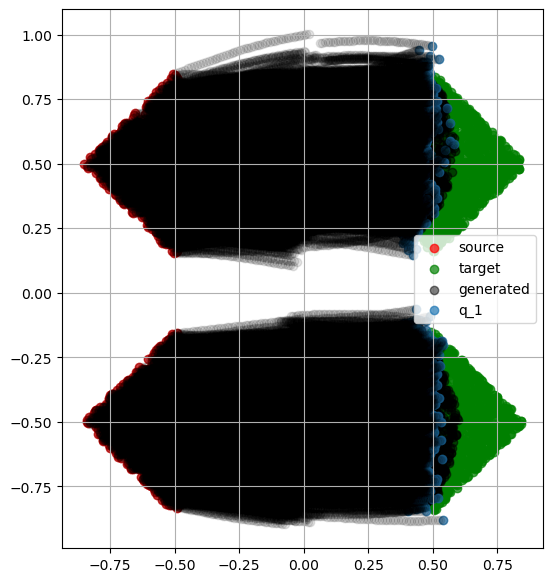

In [26]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], fc="r", alpha=0.7, label = "source")
plt.scatter(DATA_1[:,0], DATA_1[:,1], fc = "g", alpha=0.7, label = "target")
plt.scatter(x[:,-1,0], x[:,-1,1], fc="k", alpha=0.5, label = "generated")
plt.scatter(x_t[:,-1,0], x_t[:,-1,1], alpha=0.7, label = "q_1")
for i in range(DS):
  plt.scatter(x_t[i,:,0], x_t[i,:,1], c='k', alpha=0.1)
# plt.xlim(-1.5,1.5)
plt.gca().set_aspect('equal', adjustable='box')  # Make plot square
plt.legend()
plt.grid()
plt.show()

In [ ]:
import jax.numpy as jnp

dsdx_fn = jax.jit(jax.grad(lambda t, x, p: s_net.apply(p,t,x).sum(), argnums=1))

# Define x and y
xd = jnp.linspace(-2.0, 2.0, 200)
yd = jnp.linspace(-1.0, 1.0, 200)

# Create meshgrid
xx0, yy0 = jnp.meshgrid(xd, yd, indexing='ij')

# Add a singleton dimension
xx = jnp.expand_dims(xx0, axis=2)
yy = jnp.expand_dims(yy0, axis=2)

# Stack along the last dimension and swap axes
inputs = jnp.stack((xx, yy), axis=-1).squeeze()
# inputs = jnp.swapaxes(inputs, 0, -1)

num_t_steps = 6
int_time = np.unique(t)
t_step_sz = (len(int_time)-1)//(num_t_steps-1)
t_steps_idx = [t_step_sz*idx for idx in range(num_t_steps)]
t_steps = [int_time[idx] for idx in t_steps_idx]

Z = np.zeros([len(xd), len(yd)])
ZZ = np.zeros([len(t_steps), len(xd), len(yd)])
nabla_s = np.zeros((len(t_steps),) + inputs.shape)
norm_nabla_s = np.zeros_like(ZZ)


for i in range(0, len(xd)):
    # Z[i] = eta_net.apply(state_eta.model_params, inputs[i]).squeeze()
    for t_idx in range(len(t_steps)):
        tt = t_steps[t_idx]*np.ones((len(inputs[i]),1))
        ZZ[t_idx, i] = s_net.apply(state_s.model_params, t_steps[t_idx]*np.ones((len(inputs[i]),1)), inputs[i]).squeeze()  
        nabla_s[t_idx, i] = dsdx_fn(tt, inputs[i], state_s.model_params)
        norm_nabla_s[t_idx, i] = jnp.linalg.norm(nabla_s[t_idx, i], axis=1)

In [ ]:
plt.contourf(xx0, yy0, ZZ[-1], cmap="jet")
plt.colorbar()
plt.scatter(DATA_0[:,0], DATA_0[:,1], s = 10, fc="r", alpha=0.7)
plt.scatter(DATA_1[:,0], DATA_1[:,1], s = 10, fc = "g", alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], s = 10, fc="k", alpha=0.5)
for i in range(BS):
  plt.scatter(x_t[i,:,0], x_t[i,:,1], s = 10, c='b', alpha=0.3)

In [ ]:
# Compute symmetric range around 0
Z_min = np.min(ZZ)
Z_max = np.max(ZZ)
abs_max = int(np.ceil(max(abs(Z_min), abs(Z_max)) / 10.0)) * 10  # round up to nearest 10
levels = np.linspace(-abs_max, abs_max, num=11)  # 10 bins centered at 0

cmap = cm.jet
norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

fig, axs = plt.subplots(len(t_steps), 1, figsize=(10, 30))

for t_idx in range(len(axs)):
    plot = axs[t_idx].contourf(xx0, yy0, ZZ[t_idx], levels=levels, cmap=cmap, norm=norm)
    
    # Discrete colorbar centered at 0
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[t_idx], ticks=levels)
    cbar.ax.set_yticklabels([f'{l:.0f}' for l in levels])  # Optional: integer labels

    axs[t_idx].scatter(DATA_0[:,0], DATA_0[:,1], s=1, fc="r", alpha=0.7, label="$\mu$")
    axs[t_idx].scatter(DATA_1[:,0], DATA_1[:,1], s=1, fc="g", alpha=0.7, label="$\\nu$")
    axs[t_idx].scatter(x[:,t_steps_idx[t_idx],0], x[:,t_steps_idx[t_idx],1], s=1, fc="k", alpha=0.5, label="$T_\sharp\mu$")
    axs[t_idx].set_title("potential at t={:0.1f}".format(int_time[t_steps_idx[t_idx]]))
    axs[t_idx].legend()
    axs[t_idx].set_aspect('equal')